In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import random
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

device

device(type='cuda', index=0)

In [2]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        label = self.labels_df.iloc[idx, 2] if 'Labels' in self.labels_df.columns else -1
        label = label.astype(np.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
batch_size = 8

In [4]:
# Data augmentation and normalization for training
scale_factor = 16
width = int(6000/scale_factor)
height = int(4000/scale_factor)
transform = transforms.Compose([
    transforms.Resize((height,width)),
    #transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(224, padding=4),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#width = 224
#height = 224

In [5]:
train_dataset = CustomDataset(csv_file='train.csv', img_dir='images/kaggle/working/Reorganized_Data/images', transform=transform)
#test_dataset = CustomDataset(csv_file='/kaggle/input/computer-vision-xm/test.csv', img_dir='/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images', transform=transform)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size])


In [6]:
def get_gpu_dataloader(dataset,batch_size=1,shuffle=False):
    data = []
    labels = []
    for img, label in tqdm(dataset):
        data.append(img)
        labels.append(label)

    data = torch.stack(data)
    labels = torch.tensor(labels)

    data = data.to(device)
    labels = labels.to(device)

    loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(data, labels),
    batch_size=batch_size, shuffle=shuffle)
    return loader

In [7]:
# Create data loaders
train_loader = get_gpu_dataloader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = get_gpu_dataloader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = get_gpu_dataloader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 542/542 [00:42<00:00, 12.67it/s]


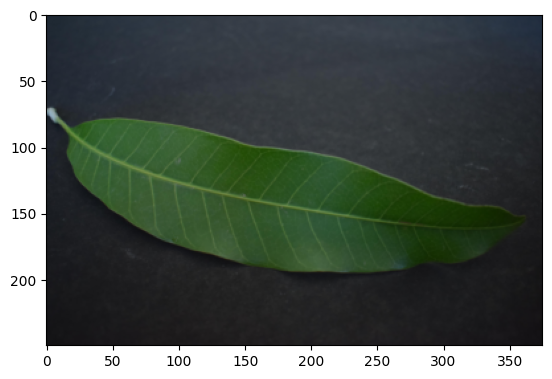

0.0


In [8]:
import torchvision.utils

import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataset)
next(dataiter)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)

In [9]:
#class CNN(nn.Module):

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3,padding=1)  # Conv layer with 3x3 kernel, depth=8
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3,padding=1)  # Conv layer with 3x3 kernel, depth=16
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # Max pooling with 2x2 kernel
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3,padding=1)  # Conv layer with 3x3 kernel, depth=32
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3,padding=1)  # Conv layer with 3x3 kernel, depth=64
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # Max pooling with 2x2 kernel
        self.fc1 = nn.Linear(64 * int(width/4) * int(height/4), 1000)  # Fully connected with 4096 nodes
        #self.fc2 = nn.Linear(4096, 1000)  # Fully connected with 1000 nodes
        self.fc3 = nn.Linear(1000, 1)  # Fully connected with 10 nodes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))#F.sigmoid(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x.reshape(-1)


model = Net()
model = model.to(device)

In [14]:
# Calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# Move the model to GPU if available
print(device)
model.to(device)

# Training loop with early stopping
epochs = 50
patience = 10
best_val_loss = float('inf')
best_val_acc = 0
patience_counter = 0

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training"):
        #images, labels = images.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.detach().item()

        # Backward pass
        loss.backward()
        optimizer.step()

    print(f'Training loss: {running_loss / len(train_loader)}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            #images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Convert the outputs to predicted class labels
            predicted = (outputs>0.5).float() #torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    print(f'Validation loss: {val_loss / len(val_loader)}')
    print(f'Validation accuracy: {val_accuracy:.4f}')

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        patience_counter = patience_counter - 1 if patience_counter > 0 else 0
        torch.save(model.state_dict(), 'best_acc_model.pth')
        print(f'Best model saved with valid acc of {val_accuracy:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_val_model.pth')
        print(f'Best model saved with valid loss of {val_loss / len(val_loader)}')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Total number of parameters: 369050529
cuda:0
Epoch 1/50


Training: 100%|██████████| 339/339 [00:20<00:00, 16.90it/s]


Training loss: 0.6601360555419528


Validation: 100%|██████████| 271/271 [00:01<00:00, 157.79it/s]


Validation loss: 0.626056419747342
Validation accuracy: 0.6471
Best model saved with valid acc of 0.6471
Best model saved with valid loss of 0.626056419747342
Epoch 2/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.69it/s]


Training loss: 0.5426499444035302


Validation: 100%|██████████| 271/271 [00:01<00:00, 168.96it/s]


Validation loss: 0.4695231310775799
Validation accuracy: 0.7869
Best model saved with valid acc of 0.7869
Best model saved with valid loss of 0.4695231310775799
Epoch 3/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.62it/s]


Training loss: 0.45791080035818715


Validation: 100%|██████████| 271/271 [00:01<00:00, 165.39it/s]


Validation loss: 0.39668611360102124
Validation accuracy: 0.8266
Best model saved with valid acc of 0.8266
Best model saved with valid loss of 0.39668611360102124
Epoch 4/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.74it/s]


Training loss: 0.380757217847668


Validation: 100%|██████████| 271/271 [00:01<00:00, 168.92it/s]


Validation loss: 0.4455100131595707
Validation accuracy: 0.7814
Epoch 5/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.83it/s]


Training loss: 0.31957208445422064


Validation: 100%|██████████| 271/271 [00:01<00:00, 167.50it/s]


Validation loss: 0.326568927526529
Validation accuracy: 0.8575
Best model saved with valid acc of 0.8575
Best model saved with valid loss of 0.326568927526529
Epoch 6/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.74it/s]


Training loss: 0.2700750783503407


Validation: 100%|██████████| 271/271 [00:01<00:00, 169.23it/s]


Validation loss: 0.3200499294978666
Validation accuracy: 0.8658
Best model saved with valid acc of 0.8658
Best model saved with valid loss of 0.3200499294978666
Epoch 7/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.32it/s]


Training loss: 0.21646087248548646


Validation: 100%|██████████| 271/271 [00:01<00:00, 169.32it/s]


Validation loss: 0.3369338572080285
Validation accuracy: 0.8639
Epoch 8/50


Training: 100%|██████████| 339/339 [00:18<00:00, 18.04it/s]


Training loss: 0.18039126668103414


Validation: 100%|██████████| 271/271 [00:01<00:00, 169.88it/s]


Validation loss: 0.4082974042482262
Validation accuracy: 0.8547
Epoch 9/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.58it/s]


Training loss: 0.14641568230040602


Validation: 100%|██████████| 271/271 [00:01<00:00, 169.64it/s]


Validation loss: 0.37289073651508736
Validation accuracy: 0.8870
Best model saved with valid acc of 0.8870
Epoch 10/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.44it/s]


Training loss: 0.1398187787393946


Validation: 100%|██████████| 271/271 [00:01<00:00, 168.63it/s]


Validation loss: 0.36595489282325955
Validation accuracy: 0.8921
Best model saved with valid acc of 0.8921
Epoch 11/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.35it/s]


Training loss: 0.10188772848630077


Validation: 100%|██████████| 271/271 [00:01<00:00, 162.79it/s]


Validation loss: 0.325214038581529
Validation accuracy: 0.9031
Best model saved with valid acc of 0.9031
Epoch 12/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.08it/s]


Training loss: 0.0730015746520243


Validation: 100%|██████████| 271/271 [00:01<00:00, 158.25it/s]


Validation loss: 0.38866751605079497
Validation accuracy: 0.9073
Best model saved with valid acc of 0.9073
Epoch 13/50


Training: 100%|██████████| 339/339 [00:18<00:00, 17.88it/s]


Training loss: 0.05259660582431073


Validation: 100%|██████████| 271/271 [00:01<00:00, 166.45it/s]


Validation loss: 0.4643697085475886
Validation accuracy: 0.8971
Epoch 14/50


Training: 100%|██████████| 339/339 [00:18<00:00, 18.10it/s]


Training loss: 0.050751643927810286


Validation: 100%|██████████| 271/271 [00:01<00:00, 170.45it/s]


Validation loss: 0.4097661146394929
Validation accuracy: 0.9054
Epoch 15/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.39it/s]


Training loss: 0.05696637165351671


Validation: 100%|██████████| 271/271 [00:01<00:00, 166.82it/s]


Validation loss: 0.5121174841565922
Validation accuracy: 0.8787
Epoch 16/50


Training: 100%|██████████| 339/339 [00:18<00:00, 18.05it/s]


Training loss: 0.08791744407588495


Validation: 100%|██████████| 271/271 [00:01<00:00, 163.31it/s]


Validation loss: 0.4189024122158663
Validation accuracy: 0.9091
Best model saved with valid acc of 0.9091
Epoch 17/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.58it/s]


Training loss: 0.02428368978491836


Validation: 100%|██████████| 271/271 [00:01<00:00, 161.19it/s]


Validation loss: 0.49937280310085685
Validation accuracy: 0.9128
Best model saved with valid acc of 0.9128
Epoch 18/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.75it/s]


Training loss: 0.026934288912788974


Validation: 100%|██████████| 271/271 [00:01<00:00, 169.63it/s]


Validation loss: 0.5240003489998747
Validation accuracy: 0.9124
Epoch 19/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.50it/s]


Training loss: 0.014826199616273596


Validation: 100%|██████████| 271/271 [00:01<00:00, 159.60it/s]


Validation loss: 0.58616738908462
Validation accuracy: 0.9137
Best model saved with valid acc of 0.9137
Epoch 20/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.59it/s]


Training loss: 0.04277879990559488


Validation: 100%|██████████| 271/271 [00:01<00:00, 169.59it/s]


Validation loss: 0.605197049599585
Validation accuracy: 0.9018
Epoch 21/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.37it/s]


Training loss: 0.036186316550151185


Validation: 100%|██████████| 271/271 [00:01<00:00, 169.12it/s]


Validation loss: 0.5791315826280178
Validation accuracy: 0.9128
Epoch 22/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.36it/s]


Training loss: 0.00892625571524018


Validation: 100%|██████████| 271/271 [00:01<00:00, 166.64it/s]


Validation loss: 0.7429972394065856
Validation accuracy: 0.9151
Best model saved with valid acc of 0.9151
Epoch 23/50


Training: 100%|██████████| 339/339 [00:19<00:00, 17.32it/s]


Training loss: 0.006058705279700839


Validation: 100%|██████████| 271/271 [00:01<00:00, 158.11it/s]


Validation loss: 0.7617913042999827
Validation accuracy: 0.9156
Best model saved with valid acc of 0.9156
Epoch 24/50


Training: 100%|██████████| 339/339 [00:20<00:00, 16.76it/s]


Training loss: 0.03288352539029121


Validation: 100%|██████████| 271/271 [00:01<00:00, 159.13it/s]


Validation loss: 0.835732545247803
Validation accuracy: 0.8838
Epoch 25/50


Training: 100%|██████████| 339/339 [00:18<00:00, 18.10it/s]


Training loss: 0.04266915787423367


Validation: 100%|██████████| 271/271 [00:01<00:00, 169.68it/s]

Validation loss: 0.874394034422686
Validation accuracy: 0.9133
Early stopping triggered


In [19]:
model.load_state_dict(torch.load('best_acc_model.pth'))
model.to(device)

# Make predictions on the test dataset
model.eval()
predictions = []
labels = []
with torch.no_grad():
    for images, label in test_loader:
        images = images.to(device)
        outputs = model(images)
        predicted = (outputs>0.5).float()
        labels.extend(label.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Create a DataFrame with IDs and predictions
submission_df = pd.DataFrame({
    #'images': test_dataset.labels_df['Images'],
    'labels': predictions,
    'groundtruth': labels
})
#submission_df.to_csv('submission.csv', index=False)
#print('Submission file was created.')
submission_df

,labels,groundtruth
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,1.0,0.0
4,0.0,0.0
...,...,...
537,0.0,0.0
538,0.0,1.0
539,1.0,1.0
540,0.0,0.0


In [20]:
(submission_df.labels == submission_df.groundtruth).mean()

np.float64(0.8985239852398524)